##### Copyright 2019 The TensorFlow Authors.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

### Import TensorFlow

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# My implementation of PyGlove 
import PyGlove as pg

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# consider just the first 1000 images to save time
train_images, train_labels  = train_images[:1000], train_labels[:1000]
test_images, test_labels =  test_images[:1000], test_labels[:1000]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


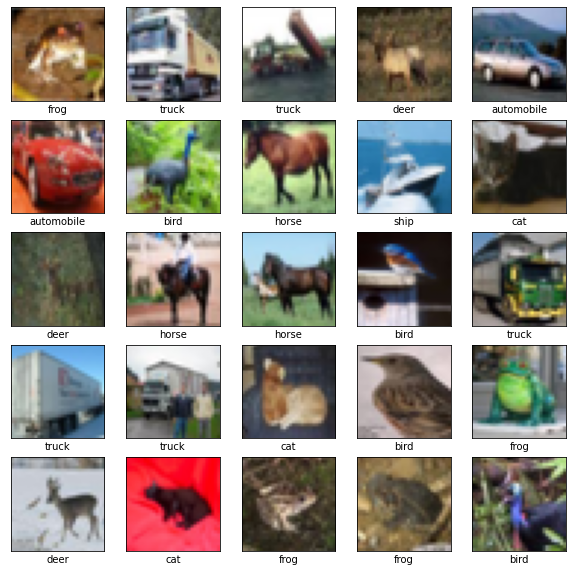

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Symbolize TensorFlow layers

In [4]:
Conv2D = pg.symbolize(layers.Conv2D)
Dense = pg.symbolize(layers.Dense)
MaxPooling2D = pg.symbolize(layers.MaxPooling2D)
Sequential = pg.symbolize(models.Sequential)

## Create the search space

In [5]:
# create a search space with three different models
# each model family has its own layer configurations
def model_builder():
    return Sequential(pg.oneof([
    # Model family 1: only dense layers .
        [
            layers.Flatten() ,
            Dense(pg.oneof([64, 128]), pg.oneof(['relu', 'sigmoid']))
        ] ,
    # Model family 2: conv net.
        [
            layers.Lambda(lambda x: tf.reshape(x, (-1, 32, 32, 3))) ,
            Conv2D(pg.oneof([64, 128]), pg.oneof([(3, 3), (5, 5)]) , activation = pg.oneof(['relu', 'sigmoid']))
        ] ,
    # Model family 3: conv net.
        [
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), 
            layers.MaxPooling2D((2, 2)), 
            layers.Conv2D(64, (3, 3), activation='relu'), 
            MaxPooling2D(pg.oneof([(2, 2), (3,3)])),
            layers.Conv2D(64, (3, 3), activation='relu')
        ]
    
        ]))

In [6]:
def train_and_evaluate(model , num_epochs =10):

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    model.fit(train_images, train_labels, epochs= num_epochs, validation_data=(test_images, test_labels))
    
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    
    return test_acc

### Train the models

In [7]:
results = []
#sampling just three models to save time
for i , model in enumerate(pg.sample(model_builder, pg.random_search, max_trails= 3)):
    # add the last dense layers to all of the sampled models
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    
    test_acc = train_and_evaluate(model)
    results.append((i, model , test_acc))

NameError: name 'tf' is not defined

### Print the results

In [ ]:
for i in range(len(results)):
    print("Model ", i, " Accuracy:", test_acc)
    model = results[i][1]
    print(model.summary())
    print("\n")